In [3]:
%matplotlib widget
import niscope as ni

# Uscita trigger dal signal generator: Pulse Sync

import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import h5py
import time
import numpy as np

import os
import sys
sys.path.insert(1, '..\\Instruments\\network\\R&S_Signal_Generator')
sys.path.insert(2, '..\\Instruments\\Acquisition_Card')
sys.path.insert(3, '..\\Instruments\\QuickSyn')
sys.path.insert(4, '..\\HDF5')

import RS_SMA100B
from Card_Class import *
from HDF5 import save_dict_to_hdf5 as hdf5_write


import FSL_0010

fsl = FSL_0010.FSL10_synthesizer(device_address='COM31')

In [4]:
ip              = '192.168.40.15'                                   # Set IP address of the device
Card_Name       = 'PXI1Slot3'
sGen            = RS_SMA100B.SMA100B(ip)
pxie            = PXIe5170R(Card_Name)

k = 2                                                               # coefficiente per prendere k*1000 punti 
                                                                    # con la scheda, dunque devo aumentare la pulse width e period

pulse_freq      = 1.010e9
amplitude       = -18                                               # Set the amplitude of the signal in dBm
sample_rate     = 250e6                                             # Maximum Value: 250.0e6
pulse_width     = k * 3e-6                                          # min 5ns                             
pulse_delay     = 0
pulse_period    = k * 5e-6                                          # min 20ns


sGen.reset()
sGen.clear()
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('SING')
sGen.RF_freq(pulse_freq)
sGen.RF_lvl_ampl(amplitude)


# parameters for the Acquisition Card
pxie.voltage_range      = 0.5
pxie.coupling           = 'AC' # or DC????
pxie.num_pts            = 1000
pxie.num_records        = 1
pxie.ref_position       = 0
pxie.sample_rate        = sample_rate                               # Maximum Value: 250.0e6



SMA100B: Connection successful!
5170R: Available communication!


In [5]:
from niscope.errors import DriverError

def trai(acquis, trig):
    global flag
    try:
        
        return acquis(trig)
    except DriverError:
        flag += 1
        print(flag)
        
        if flag <= 10:
            print('PROVO')
            trai(acquis, trig)
        else:
            print('ERRORE')
        return [[],[],[],[]]

- P cycle: 0
11.11111111111111 %
22.22222222222222 %
33.333333333333336 %
- P cycle: 1
44.44444444444444 %


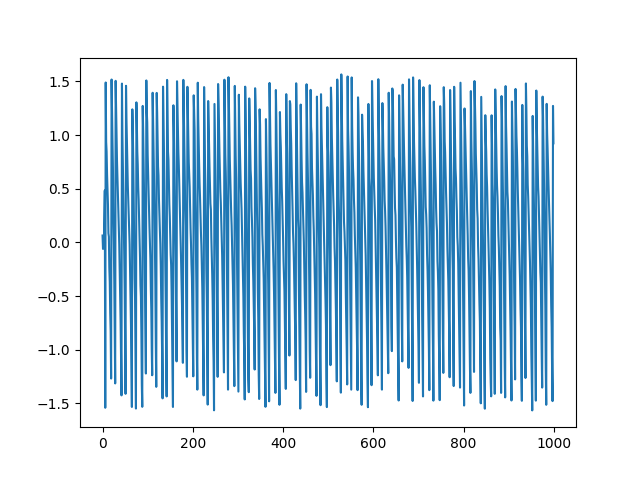

55.55555555555556 %
66.66666666666667 %
- P cycle: 2
77.77777777777777 %
88.88888888888889 %
100.0 %


In [7]:
# FSL-0010
fsl.set_frequency(1) # GHz
fsl.set_output('ON')
pxie.open()

pota        = np.arange(amplitude, amplitude + 3 , 1)
pula        = np.arange(pulse_freq, pulse_freq + 0.003e9, 0.001e9)

amplidick   = {}
counter     = 1


digits_p = "{:0"+str(len(str(len(pota))))+"d}"
digits_f = "{:0"+str(len(str(len(pula))))+"d}"
for p, pot in enumerate(pota):
    print('- P cycle:', p)
    amplidick[f'p{digits_p.format(p)}'] = {'power_(dBm)': pot, 'freqs': {}}
    sGen.RF_lvl_ampl(pot)

    for i, pul in enumerate(pula):
        
        sGen.RF_freq(pul) # guarda come è definito, abbiamo messo la potenza e6   
        sGen.pul_state(1)
        sGen.RF_state(1)
        # time.sleep(3)
        flag = 0
        waveforms = []
        try:
            waveforms = pxie.acquisition(sGen.pul_exe_sing_trig)
        except DriverError:
            while(flag<=10 and ni.Session.acquisition_status=='IN_PROGRESS') :
              flag += 1
              print(flag)
              waveforms = pxie.acquisition(sGen.pul_exe_sing_trig)
              


        #waveforms = trai(pxie.acquisition, sGen.pul_exe_sing_trig)
        #print(waveforms)
        I = np.array(waveforms[3].samples.tolist())
        Q = np.array(waveforms[2].samples.tolist())
        if p == 1 and i == 1:
          plt.clf()
          #plt.plot(np.sqrt(I**2 + Q**2))
          plt.plot(np.arctan(Q/I))
          plt.show()
        
        sGen.pul_state(0)
        sGen.RF_state(0)

        print(counter*100/(len(pota)*len(pula)),'%')
        counter += 1
        amplidick[f'p{digits_p.format(p)}']['freqs'][f'f{digits_f.format(i)}'] = {'freq_(Hz)': pul, 'I': I, 'Q': Q}
fsl.set_output('OFF')


# SAVE DATA ON HDF5 FILE
filename = 'amplitrix2_IQMixer.hdf5'
if os.path.exists(filename):
  os.remove(filename)
hdf5_write(amplidick, filename)